#### The goal of this is to produce a house value based on data retrieved from multiple data sources

In [34]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from PostcodeToCoordinates import PostcodeGeocode
import matplotlib
import matplotlib.pyplot as plt

##  Import Data and Setup

In [2]:
# Import the price paid dataset from the Land Registry API for the Chester Area

price_df = pd.read_csv('price_paid_CHESTER.csv', index_col = 0)

# Parse the dates to get year/month from datetime
price_df['datetime'] = pd.to_datetime(price_df['Transaction Date'])
price_df['year'] = price_df['datetime'].apply(lambda x: x.year)

# Concat the postcode and house number to merge on
price_df['postcode_number'] = price_df['PAON']+' '+price_df['Postcode']

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
price_df.tail()

,url,Price Paid,Transaction Date,Transaction Id,Type,About,PAON,Postcode,Street Name,datetime,year,postcode_number
183,http://landregistry.data.gov.uk/data/ppi/trans...,740000,"Thu, 30 Sep 2021",D4D42645-57A5-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,PEAR TREE COTTAGE,CH3 7JY,BARNHOUSE LANE,2021-09-30,2021,PEAR TREE COTTAGE CH3 7JY
184,http://landregistry.data.gov.uk/data/ppi/trans...,283000,"Fri, 19 Nov 2021",D4D42645-56F9-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,26,CH1 2NE,BRENNUS PLACE,2021-11-19,2021,26 CH1 2NE
185,http://landregistry.data.gov.uk/data/ppi/trans...,220000,"Fri, 08 Oct 2021",D4D42646-7DAE-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,7,CH4 0PY,BLACKTHORN CLOSE,2021-10-08,2021,7 CH4 0PY
186,http://landregistry.data.gov.uk/data/ppi/trans...,364400,"Fri, 18 Jun 2021",D4D42645-57E4-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,45,CH2 2PN,ULLSWATER CRESCENT,2021-06-18,2021,45 CH2 2PN
187,http://landregistry.data.gov.uk/data/ppi/trans...,210000,"Thu, 30 Sep 2021",D4D42645-54B4-27F6-E053-6C04A8C0A572,['http://landregistry.data.gov.uk/def/ppi/Tran...,http://landregistry.data.gov.uk/data/ppi/addre...,12,CH3 5DL,LORD STREET,2021-09-30,2021,12 CH3 5DL


In [4]:
# Import the EPC data (Only for CH1)

epc_df = pd.read_csv('epc_CH1.csv', index_col = 0)

# Need to construct a field to merge on
# The data formatting is awful...need to use regex to clean up
# This is a quick and dirty attempt...need to study edge cases and try to improve

def clean_data(x):
    if ',' in x:
        return x.split(',')[0]
    else:
        split = x.split(' ')
        for i in split:
            try:
                num = int(split[0])
                return num
            except:
                pass
        return split[0]
        

epc_df['house/number'] = epc_df['address1'].apply(lambda x: clean_data(x))
epc_df['house/number'] = epc_df['house/number'].apply(lambda x: str(x))
epc_df['postcode_number'] = epc_df['house/number']+' '+epc_df['postcode']


epc_df.head()

,lmk-key,address1,address2,address3,postcode,building-reference-number,current-energy-rating,potential-energy-rating,current-energy-efficiency,potential-energy-efficiency,...,posttown,construction-age-band,lodgement-datetime,tenure,fixed-lighting-outlets-count,low-energy-fixed-light-count,uprn,uprn-source,house/number,postcode_number
0,691200819902019042819015293112888,"7, Tennyson Walk",Blacon,NaN,CH1 5UN,2919111968,A,A,92,94,...,CHESTER,England and Wales: 1967-1975,2019-04-28 19:01:52,owner-occupied,NaN,NaN,2.000008e+11,Address Matched,7,7 CH1 5UN
1,692126352812017030820535191030696,"2, Meadowcroft",Saughall,NaN,CH1 6EU,6688211968,A,A,93,96,...,CHESTER,England and Wales: 1976-1982,2017-03-08 20:53:51,owner-occupied,NaN,NaN,1.000100e+11,Address Matched,2,2 CH1 6EU
2,288745278612009052014570601910069,Apartment 123 The Quarter,Egerton Street,NaN,CH1 3NR,916812668,A,A,94,96,...,CHESTER,England and Wales: 2003-2006,2009-05-20 14:57:06,owner-occupied,NaN,NaN,1.000008e+10,Address Matched,Apartment,Apartment CH1 3NR
3,b0cde21277dd10b73f076fadd46c051db5c5d84e5a87f0...,3 Tillage Close,Backford,NaN,CH1 6PZ,10001513495,B,B,84,84,...,CHESTER,2020,2021-09-30 14:45:38,Not defined - use in the case of a new dwellin...,10.0,NaN,1.009468e+10,Energy Assessor,3,3 CH1 6PZ
4,dd374d1e4a1b52185a2b1031e55f74d4cef4770537eb55...,Eden House,Well Lane,Mollington,CH1 6LD,10001642164,B,B,87,91,...,Chester,2021,2021-09-30 10:34:32,Not defined - use in the case of a new dwellin...,100.0,NaN,NaN,NaN,Eden,Eden CH1 6LD


In [5]:
# Merge the datasets

merged_df = pd.merge(price_df, epc_df, how = 'left', left_on = 'postcode_number', right_on = 'postcode_number')

# Delete records where there isn't a UPRN

merged_df.dropna(subset = ['uprn'], inplace = True)

/tmp/ipykernel_8861/777847877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['Price Paid'] = df_21['Price Paid'].apply(lambda x: int(x))


<AxesSubplot:ylabel='Density'>

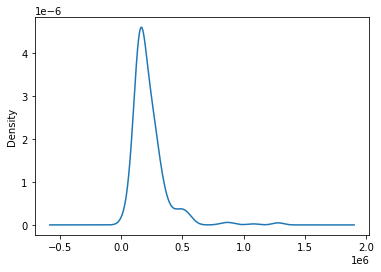

In [6]:
### Examine most recent year - 2021 in this instance
# Change to examine year in date time rather than int val?

df_21 = merged_df[merged_df['year']==2021]

df_21['Price Paid'] = df_21['Price Paid'].apply(lambda x: int(x))

df_21['Price Paid'].plot.kde()

In [7]:
df_21['Price Paid'].describe()

count    3.680000e+02
mean     2.282449e+05
std      1.467426e+05
min      4.000000e+04
25%      1.497500e+05
50%      1.850000e+05
75%      2.700000e+05
max      1.280000e+06
Name: Price Paid, dtype: float64

## 1. Linear Regression Model

In [8]:
### Build Model based on the relationship between price paid and area

# Training data
X = np.array(df_21['total-floor-area'])
X = X.reshape(-1, 1)

# Target data
y = np.array(df_21['Price Paid'].values)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

/tmp/ipykernel_8861/2035156034.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_test,y_pred, 'k-', color = 'r')


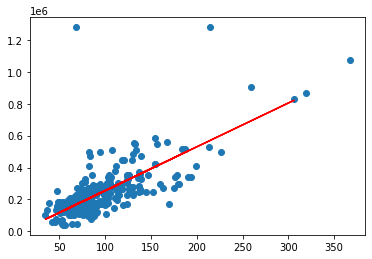

Coefficients: 
 [[2752.09096317]]
Mean squared error: 4004755460.83
Coefficient of determination: 0.61


In [9]:
# Plot linear regression

plt.scatter(df_21['total-floor-area'],df_21['Price Paid'])
plt.plot(X_test,y_pred, 'k-', color = 'r')
plt.show()

# The coefficients
print("Coefficients: \n", regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

## 2. Multiple Linear Regression Model

In [72]:
### Adjust features and data format

## Use one-hot encoding to classify for property type

for i in df_21['property-type'].unique():
    var_name = 'is'+i
    df_21[var_name] = np.where(df_21['property-type']==i,1,0)
    
## Convert categorical to numerical


rating_dict = {
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5,
    'F':6, 
    'G':7
}

df_21['rating_num'] = df_21['current-energy-rating'].apply(lambda x: rating_dict[x])

## Number of Habitable Rooms
# Replace null values with median

def clean_rooms(x):
    if isinstance(x,float):
        return x
    else:
        return np.nan
    
df_21['number-habitable-rooms'] = df_21['number-habitable-rooms'].apply(clean_rooms)
med_val = np.median(df_21['number-habitable-rooms'].dropna())

df_21['number-habitable-rooms'] = df_21['number-habitable-rooms'].fillna(value = med_val)

df_21['room-size'] = df_21['total-floor-area']/df_21['number-habitable-rooms']


/tmp/ipykernel_8861/2304115410.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21[var_name] = np.where(df_21['property-type']==i,1,0)
/tmp/ipykernel_8861/2304115410.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['rating_num'] = df_21['current-energy-rating'].apply(lambda x: rating_dict[x])
/tmp/ipykernel_8861/2304115410.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [56]:
### Geocode the postcode

df_21['lat'], df_21['long'] = PostcodeGeocode((df_21['postcode']))

df_21['lat'] = df_21['lat'].astype(float)

df_21['long'] = df_21['long'].astype(float)

### Identify distance from Railway Station/Town Centre

chester_station = [53.196502, -2.880304]

chester_town = [53.190249, -2.891639]

# Returns distance in degrees using simple euclidean distance

def distance_station(lat,long, feature = chester_station):
    return math.sqrt((feature[0]-lat)**2 + (feature[1]-long)**2)

def distance_town(lat,long, feature = chester_town):
    return math.sqrt((feature[0]-lat)**2 + (feature[1]-long)**2)

df_21['distance-station'] = list(map(distance_station,df_21['lat'],df_21['long']))
df_21['distance-town'] = list(map(distance_town,df_21['lat'],df_21['long']))


/tmp/ipykernel_8861/3128799742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['lat'], df_21['long'] = PostcodeGeocode((df_21['postcode']))
/tmp/ipykernel_8861/3128799742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_21['lat'] = df_21['lat'].astype(float)
/tmp/ipykernel_8861/3128799742.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [75]:
### Build Model based on the relationship between price paid and area

# Training data
X = np.array(df_21[['total-floor-area','isHouse','isFlat','rating_num','room-size']])


# Target data
y = np.array(df_21['Price Paid'].values)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

# The coefficients
print("Coefficients: \n", regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [[  2071.6044139  -23562.31110892   1692.45658481   1217.36340565
    7665.300791  ]]
Mean squared error: 5213037367.14
Coefficient of determination: 0.49


Despite engineering a number of additional features to be used in this model, this did not help reduce the mean squared error. In fact, more data only decreased the coefficient of determination and increased the MSE suggesting that adding more data is not going to help improve the prediction. 

Producing a correlation matrix like the one below can help identify potential linear relationships better than trial and error. It's worth noting that the feature with the second highest correlation score, "room-size", is derivative of "total-floor-area". While this chart can help identify correlation, it can't warn about multicollinearity. 

In [74]:
### Plot a correlation matrix

## Focus on specific numeric attributes

attributes = df_21[['Price Paid','rating_num','distance-station','distance-town','number-habitable-rooms','total-floor-area','room-size']]

corr = attributes.corr()
corr.style.background_gradient(cmap='coolwarm')

,Price Paid,rating_num,distance-station,distance-town,number-habitable-rooms,total-floor-area,room-size
Price Paid,1.000000,0.031377,0.110035,0.094238,0.345912,0.724232,0.625064
rating_num,0.031377,1.000000,0.039032,0.022530,0.079824,0.069603,0.029301
distance-station,0.110035,0.039032,1.000000,0.975299,0.129921,0.194524,0.120107
distance-town,0.094238,0.022530,0.975299,1.000000,0.095313,0.185486,0.142080
number-habitable-rooms,0.345912,0.079824,0.129921,0.095313,1.000000,0.650467,-0.085040
total-floor-area,0.724232,0.069603,0.194524,0.185486,0.650467,1.000000,0.672428
room-size,0.625064,0.029301,0.120107,0.142080,-0.085040,0.672428,1.000000


## 3. Random Forest Regressor

In [ ]:
### Set up Random Forest model

# Training data
X = np.array(df_21[['total-floor-area','isHouse','isFlat','rating_num','room-size']])


# Target data
y = np.array(df_21['Price Paid'].values)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regr = RandomForestRegressor(max_depth=2, random_state=0)